In [2]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/dro/temp/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim

from scipy.stats import invgamma, norm

/work/dro/temp/2d
['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/omnisafe/venv/lib/python3.10/site-packages', '__editable__.omnisafe-0.5.1.dev27+g080e6b8.finder.__path_hook__', '/home/omnisafe/venv/lib/python3.10/site-packages/pytorch_lightning-2.4.0-py3.10.egg', '/home/omnisafe/venv/lib/python3.10/site-packages/pandas-2.0.3-py3.10-linux-x86_64.egg', '/work/DRO-EDL/1d/evidential-learning-pytorch']


In [3]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arctan2(y,x)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

In [4]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 2),
)
model.load_state_dict(torch.load(f'uncertain_weights/{90}.pth', weights_only=True))


<All keys matched successfully>

In [5]:
def NIG_sample(params):
    mu_0, lambda_, alpha, beta = params
    x_sigma2_dist = invgamma(alpha, scale=beta)
    sigma2 = x_sigma2_dist.rvs(1)
    x_mu_dist = norm(mu_0, np.sqrt(sigma2 / lambda_))
    mu = x_mu_dist.rvs(1)
    return np.array([mu[0], sigma2[0]])

In [6]:
import pickle
a_memory = dict()
with open(f'../1d/a_memory_set/a_memory_{0.9}.pickle', 'rb') as f:
    a_memory = pickle.load(f)

In [7]:
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider

def plot(x, y):
    fig, ax = plt.subplots(figsize=(8,8))
    
    print(x, y)
    sample = [x, y]
    input_data = torch.tensor(cart2polar(*sample), dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)
    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]

    
    # ambiguity set
    ## x axis
    mu_0, lambda_, alpha, beta = x_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    x_mu_low, x_mu_high = mu_0 - delta, mu_0 + delta
    
    ## y axis
    mu_0, lambda_, alpha, beta = y_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    y_mu_low, y_mu_high = mu_0 - delta, mu_0 + delta
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    # sampling
    for _ in range(500):
        x_dist_params = NIG_sample(x_params)
        y_dist_params = NIG_sample(y_params)

        mean = np.array([x_dist_params[0], y_dist_params[0]])
        cov = np.array([
            [x_dist_params[1], 0],
            [0, y_dist_params[1]]
        ])


        # 공분산 행렬의 고유값과 고유벡터 계산
        eigvals, eigvecs = np.linalg.eigh(cov)

        # 1-sigma 수준에서 타원의 축 반지름 계산
        axis_lengths = np.sqrt(eigvals)

        # 타원의 각도 계산 (라디안)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

        # 타원 좌표 생성
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

        # 타원의 회전 적용
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        rotated_ellipse = rotation_matrix @ ellipse

        # 타원을 평균 좌표로 이동
        ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]
        if (x_mu_low < mean[0] and mean[0] < x_mu_high) and (y_mu_low < mean[1] and mean[1] < y_mu_high):
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        plt.plot(ellipse_x, ellipse_y, color=color, alpha=alpha, label=label)
    ax.add_patch(rectangle)

    plt.scatter(*sample, color='g', label='Ground Truth')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 중복 제거

    # 고유한 레이블만 포함하는 legend 표시
    plt.legend(unique_labels.values(), unique_labels.keys())   
    plt.show()


interact(
        plot,
        x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);


interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

In [8]:
def plot_ellipse(mean, covariance, n_std=2, ax=None, **kwargs):
    """
    평균과 공분산 행렬을 사용하여 타원을 그립니다.

    Parameters:
    - mean: 1x2 배열, 타원의 중심 (평균 벡터)
    - covariance: 2x2 배열, 공분산 행렬
    - n_std: float, 타원의 크기를 결정하는 표준편차의 배수 (기본값: 2)
    - ax: matplotlib 축 객체 (기본값: None)
    - kwargs: matplotlib.patches.Ellipse에 전달할 추가 스타일 인수

    Returns:
    - 타원을 그린 matplotlib Ellipse 객체
    """
    from matplotlib.patches import Ellipse
    if ax is None:
        ax = plt.gca()

    # 공분산 행렬의 고유값과 고유벡터 계산
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)

    # 고유값의 제곱근으로 타원의 축 길이 결정
    axis_length = n_std * np.sqrt(eigenvalues)

    # 고유벡터에서 타원의 회전 각도 계산
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # 타원 생성
    ellipse = Ellipse(
        xy=mean,
        width=2 * axis_length[0],
        height=2 * axis_length[1],
        angle=angle,
        **kwargs
    )

    # 타원을 플롯에 추가
    ax.add_patch(ellipse)

    return ellipse

In [9]:
point_x, point_y = 7, 2
N = 2
mu_x = torch.linspace(1, 4, N)
mu_y = torch.linspace(6, 10, N)


vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]

rectangle = Polygon(vertices, closed=True, color='red')

sigma2_x = torch.linspace(1.1, 1.7, N)
sigma2_y = torch.linspace(1.6, 2.4, N)

mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
# means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()]).T
means = torch.tensor([1, 6])[None,:]


sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")

pairs = torch.stack([sigma2_x_grid.flatten(), sigma2_y_grid.flatten()])
z = torch.zeros_like(pairs[0,:])
# cov = torch.stack([pairs[0,:], z, z, pairs[1,:]], dim=0).reshape(2,2,-1).permute(2,0,1)
cov = torch.tensor([[1.1, 0], [0, 1.6]])[None,:]

print("COIV")
print(cov)
chol_matrices = torch.linalg.cholesky(cov)
print("L")
print(chol_matrices)
# cholesky_matrix.shape


# Unscented transformation parameters
alpha = 1e-3  # Scale factor
beta = 2.0    # Optimal for Gaussian distributions
kappa = 0.0   # Secondary scaling parameter
n = means.shape[1]
lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

# Compute weights
Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
Wm[0] = lambda_ / (n + lambda_)

Wc = Wm.clone()  # Covariance weights
Wc[0] += 1 - alpha**2 + beta

# Generate sigma points for the entire batch
scaling = torch.sqrt(n + lambda_)
sigma_points = []

# Central sigma points
sigma_points.append(means)

# Positive and negative directions
for i in range(n):
    sigma_points.append(means + scaling * chol_matrices[:, :, i])
    sigma_points.append(means - scaling * chol_matrices[:, :, i])

# Stack sigma points into a batch tensor
sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)
print("sigma points")
print(sigma_points)
# Nonlinear transformation function (example)
# def nonlinear_transform(x):
#     return torch.stack([x[..., 0]**2, torch.sin(x[..., 1])], dim=-1)
def nonlinear_transform(x):
    target = torch.tensor([point_x, point_y])  # Point (3, 4)
    distance = -torch.sqrt(torch.sum((x - target)**2, dim=-1))  # Euclidean distance
    return distance[..., None]  # Add last dimension for compatibility


# Apply the nonlinear transformation to all sigma points
transformed_sigma_points = nonlinear_transform(sigma_points)
print("transform")
print(transformed_sigma_points)
# Compute transformed means (batch)
print(transformed_sigma_points)
transformed_means = torch.sum(Wm[None, :, None] * transformed_sigma_points, dim=1)
print("means")
print(transformed_means.item())
# Compute transformed covariances (batch)
diff = transformed_sigma_points - transformed_means[:, None, :]
transformed_covariances = torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)
print("cov")
print(transformed_covariances)
epsilon = torch.tensor(0.95)
gamma = torch.sqrt(epsilon / (1-epsilon))
transformed_means.squeeze().shape, transformed_covariances.squeeze().shape
CVaR = transformed_means.squeeze() + gamma * transformed_covariances.squeeze()
min_idx = CVaR.argmax()


COIV
tensor([[[1.1000, 0.0000],
         [0.0000, 1.6000]]])
L
tensor([[[1.0488, 0.0000],
         [0.0000, 1.2649]]])
sigma points
tensor([[[1.0000, 6.0000],
         [1.0015, 6.0000],
         [0.9985, 6.0000],
         [1.0000, 6.0018],
         [1.0000, 5.9982]]])
transform
tensor([[[-7.2111],
         [-7.2099],
         [-7.2123],
         [-7.2121],
         [-7.2101]]])
tensor([[[-7.2111],
         [-7.2099],
         [-7.2123],
         [-7.2121],
         [-7.2101]]])
means
-7.75
cov
tensor([[[2.2812]]])


In [11]:
import time
st = time.time()
point_x, point_y = 30, 40
N = 200
mu_x = torch.linspace(12, 30, N)
mu_y = torch.linspace(40, 60, N)


vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]

rectangle = Polygon(vertices, closed=True, color='red')

sigma2_x = torch.linspace(0.1, 3, N)
sigma2_y = torch.linspace(0.1, 3, N)

mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()]).T

sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")

pairs = torch.stack([sigma2_x_grid.flatten(), sigma2_y_grid.flatten()])
z = torch.zeros_like(pairs[0,:])
cov = torch.stack([pairs[0,:], z, z, pairs[1,:]], dim=0).reshape(2,2,-1).permute(2,0,1)

chol_matrices = torch.linalg.cholesky(cov)
# cholesky_matrix.shape


# Unscented transformation parameters
alpha = 1e-3  # Scale factor
beta = 2.0    # Optimal for Gaussian distributions
kappa = 0.0   # Secondary scaling parameter
n = means.shape[1]
lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

# Compute weights
Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
Wm[0] = lambda_ / (n + lambda_)

Wc = Wm.clone()  # Covariance weights
Wc[0] += 1 - alpha**2 + beta

# Generate sigma points for the entire batch
scaling = torch.sqrt(n + lambda_)
sigma_points = []

# Central sigma points
sigma_points.append(means)

# Positive and negative directions
for i in range(n):
    sigma_points.append(means + scaling * chol_matrices[:, :, i])
    sigma_points.append(means - scaling * chol_matrices[:, :, i])

# Stack sigma points into a batch tensor
sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)

# Nonlinear transformation function (example)
# def nonlinear_transform(x):
#     return torch.stack([x[..., 0]**2, torch.sin(x[..., 1])], dim=-1)
def nonlinear_transform(x):
    target = torch.tensor([point_x, point_y])  # Point (3, 4)
    distance = 10-torch.sqrt(torch.sum((x - target)**2, dim=-1))  # Euclidean distance
    return distance  # Add last dimension for compatibility


# Apply the nonlinear transformation to all sigma points
transformed_sigma_points = nonlinear_transform(sigma_points)

# Compute transformed means (batch)
transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

# Compute transformed covariances (batch)
diff = transformed_sigma_points - transformed_means[:, None]
transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)

epsilon = torch.tensor(0.95)
gamma = torch.sqrt(epsilon / (1-epsilon))
transformed_means.squeeze().shape, transformed_covariances.squeeze().shape
CVaR = transformed_means.squeeze() + gamma * transformed_covariances.squeeze()
max_idx = CVaR.argmax()
print('means, cov')
print(means[max_idx], cov[max_idx])
print(time.time() - st)

means, cov
tensor([29.1859, 40.2010]) tensor([[2.8688, 0.0000],
        [0.0000, 0.1291]])
0.013811349868774414


In [12]:
epsilon = 0.95
target_cdf = 0.50
kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
import pickle

with open(f'../1d/a_memory_set/a_memory_{target_cdf}.pickle', 'rb') as fr:
    a_memory = pickle.load(fr)

In [457]:
import time
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

st = time.time()

def plot(point_x,point_y, obs_x, obs_y, obs_sx, obs_sy):
    N = 200
    mu_x = torch.linspace(-25, 30, N)
    mu_y = torch.linspace(-30, 20, N)
    
    
    vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    
    sigma2_x = torch.linspace(0.1, 3, N)
    sigma2_y = torch.linspace(0.1, 3, N)

    mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
    means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()]).T

    sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")

    pairs = torch.stack([sigma2_x_grid.flatten(), sigma2_y_grid.flatten()])
    z = torch.zeros_like(pairs[0,:])
    cov = torch.stack([pairs[0,:], z, z, pairs[1,:]], dim=0).reshape(2,2,-1).permute(2,0,1)

    chol_matrices = torch.linalg.cholesky(cov)
    print("DBG")
    print(chol_matrices.shape)
    # cholesky_matrix.shape


    # Unscented transformation parameters
    alpha = 1e-3  # Scale factor
    beta = 2.0    # Optimal for Gaussian distributions
    kappa = 0.0   # Secondary scaling parameter
    n = means.shape[1]
    lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

    # Compute weights
    Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
    Wm[0] = lambda_ / (n + lambda_)

    Wc = Wm.clone()  # Covariance weights
    Wc[0] += 1 - alpha**2 + beta

    # Generate sigma points for the entire batch
    scaling = torch.sqrt(n + lambda_)
    sigma_points = []

    # Central sigma points
    sigma_points.append(means)

    # Positive and negative directions
    for i in range(n):
        sigma_points.append(means + scaling * chol_matrices[:, :, i])
        sigma_points.append(means - scaling * chol_matrices[:, :, i])

    # Stack sigma points into a batch tensor
    sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)

    # Nonlinear transformation function (example)
    # def nonlinear_transform(x):
    #     return torch.stack([x[..., 0]**2, torch.sin(x[..., 1])], dim=-1)
    def nonlinear_transform(x):
        target = torch.tensor([point_x, point_y])  # Point (3, 4)
        distance = 10-torch.sqrt(torch.sum((x - target)**2, dim=-1))  # Euclidean distance
        return distance  # Add last dimension for compatibility


    # Apply the nonlinear transformation to all sigma points
    transformed_sigma_points = nonlinear_transform(sigma_points)

    # Compute transformed means (batch)
    transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

    # Compute transformed covariances (batch)
    diff = transformed_sigma_points - transformed_means[:, None]
    transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)

    epsilon = torch.tensor(0.95)
    gamma = torch.sqrt(epsilon / (1-epsilon))
    CVaR = transformed_means.squeeze() + gamma * transformed_covariances.squeeze()
    max_idx = CVaR.argmax()
    print('means, cov')
    print(means[max_idx], cov[max_idx])
    print('max CVaR: ', CVaR.max())

    

    
    
    
    
    
    
    
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    ax[0].add_patch(rectangle)
    
    plot_ellipse(means[max_idx], cov[max_idx], n_std=2, ax=ax[0])
    
    ax[0].scatter(point_x, point_y)
    ax[0].set_xlim(-100, 100)
    ax[0].set_ylim(-100, 100)
    
    ax[1].hist(CVaR, bins=100)
    
    # Calculate New CVaR
    
    mean = torch.tensor([mu_x.min(), mu_y.min()])[None,:]
    cov = torch.tensor([
        [sigma2_x.max(), 0],
        [0, sigma2_y.max()]
    ])[None,:]
    
    mean = torch.tensor([obs_x, obs_y])[None,:]
    cov = torch.tensor([
        [obs_sx, 0],
        [0, obs_sy]
    ])[None,:]
    L = torch.linalg.cholesky(cov)
    
    sigma_points = list()
    sigma_points.append(mean)
    for i in range(n):
        sigma_points.append(mean + scaling * L[:, :, i])
        sigma_points.append(mean - scaling * L[:, :, i])
    sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)
    # Apply the nonlinear transformation to all sigma points
    transformed_sigma_points = nonlinear_transform(sigma_points)

    # Compute transformed means (batch)
    transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

    # Compute transformed covariances (batch)
    diff = transformed_sigma_points - transformed_means[:, None]
    transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)
    CVaR = transformed_means.squeeze() + gamma * transformed_covariances.squeeze()
    print("new mean, cov: ",transformed_means.squeeze(), transformed_covariances.squeeze())
    print("new CVaR: ",CVaR)
    ax[1].scatter(CVaR, 0, color='r')
    plot_ellipse(mean[0], cov[0], n_std=2, ax=ax[0], color='green')

    
interact(
        plot,
        point_x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        point_y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
        obs_x=FloatSlider(min=12, max=30, step=0.1, value=0, description='Minor Axis (b)'),
        obs_y=FloatSlider(min=40, max=60, step=0.1, value=0, description='Minor Axis (b)'),
        obs_sx=FloatSlider(min=0.1, max=3, step=0.1, value=0, description='Minor Axis (b)'),
        obs_sy=FloatSlider(min=0.1, max=3, step=0.1, value=0, description='Minor Axis (b)'),
);



interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

# use Mahalanobis distance for closed form solution

In [461]:
import time
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

st = time.time()

def plot(point_x,point_y):
    N = 20
    mu_x = torch.linspace(-25, 25, N)
    mu_y = torch.linspace(-25, 25, N)
    
    
    vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]
    
    rectangle = Polygon(vertices, closed=True, color='red')

    s_N = 10
    sigma2_x = torch.linspace(0.1, 3, s_N)
    sigma2_y = torch.linspace(0.1, 3, s_N)

    mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
    means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()])

    sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")

    z = torch.zeros_like(sigma2_x_grid).flatten()

    covs = torch.stack([sigma2_x_grid.flatten(), z, z, sigma2_y_grid.flatten()])
    print(means.shape, covs.shape)
    Mu = means.repeat(s_N * s_N, 1, 1).permute(0,2,1).transpose(0,1).flatten(0,1)
    Sigma = covs.repeat(N * N, 1, 1).permute(0,2,1).flatten(0,1)

    print(Mu.shape, Sigma.shape)
    samples = torch.cat([Mu, Sigma], dim=1)
    
    mean_list = samples[:,:2]
    cov_list = samples[:,2:].reshape(-1,2,2)
    # mean_list = means.repeat(s_N*s_N, 1)
    # cov_list = cov.repeat(N*N, 1, 1)
    
    chol_matrices = torch.linalg.cholesky(cov_list)
    print("DBG")
    print(chol_matrices.shape)


    # Unscented transformation parameters
    alpha = 1e-3  # Scale factor
    beta = 2.0    # Optimal for Gaussian distributions
    kappa = 0.0   # Secondary scaling parameter
    n = means.shape[0]
    lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

    # Compute weights
    Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
    Wm[0] = lambda_ / (n + lambda_)

    Wc = Wm.clone()  # Covariance weights
    Wc[0] += 1 - alpha**2 + beta

    # Generate sigma points for the entire batch
    scaling = torch.sqrt(n + lambda_)
    sigma_points = []

    # Central sigma points
    sigma_points.append(mean_list)

    # Positive and negative directions
    for i in range(n):
        sigma_points.append(mean_list + scaling * chol_matrices[:, :, i])
        sigma_points.append(mean_list - scaling * chol_matrices[:, :, i])

    # Stack sigma points into a batch tensor
    sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)

    # Nonlinear transformation function (example)
    # def nonlinear_transform(x):
    #     return torch.stack([x[..., 0]**2, torch.sin(x[..., 1])], dim=-1)
    def nonlinear_transform(x):
        target = torch.tensor([point_x, point_y])  # Point (3, 4)
        distance = 10-torch.sqrt(torch.sum((x - target)**2, dim=-1))  # Euclidean distance
        return distance  # Add last dimension for compatibility


    # Apply the nonlinear transformation to all sigma points
    transformed_sigma_points = nonlinear_transform(sigma_points)

    # Compute transformed means (batch)
    transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

    # Compute transformed covariances (batch)
    diff = transformed_sigma_points - transformed_means[:, None]
    transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)

    epsilon = torch.tensor(0.95)
    gamma = torch.sqrt(epsilon / (1-epsilon))
    CVaR = transformed_means.squeeze() + gamma * transformed_covariances.squeeze()
    max_idx = CVaR.argmax()
    print('means, cov')
    print(mean_list[max_idx], cov_list[max_idx])
    print('max CVaR: ', CVaR.max())

    

    
    
    
    
    
    
    
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    ax[0].add_patch(rectangle)
    
    plot_ellipse(mean_list[max_idx], cov_list[max_idx], n_std=2, ax=ax[0])
    
    ax[0].scatter(point_x, point_y)
    ax[0].set_xlim(-100, 100)
    ax[0].set_ylim(-100, 100)
    
    # ax[1].hist(CVaR, bins=100)
    

    # Mahalanobis distance minimum distribution

    diff = torch.tensor([point_x, point_y]) - mean_list
    inv_cov = np.linalg.inv(cov_list)
        
    dist = np.sqrt(diff[:,None,:] @ inv_cov @ diff[:,None,:].permute(0,2,1))
    print(dist.squeeze())
    ax[1].hist(dist.squeeze(), bins=100)
    min_dist_idx = dist.squeeze().argmin().item()
    print("mahalanobis min dist: ",dist[min_dist_idx])
    print(mean_list[min_dist_idx])
    print(cov_list[min_dist_idx])
    print('='*30)
    print(diff.norm(dim=1)[min_dist_idx])
    print(mean_list[max_idx])
    print(cov_list[max_idx])
    new_diff = torch.tensor([point_x, point_y]) - mean_list[max_idx]
    print("new diff: ",new_diff)
    new_inv_cov = np.linalg.inv(cov_list[max_idx])
    new_dist = np.sqrt(new_diff @ new_inv_cov @ new_diff.T)
    print("new_dist: ",new_dist)
    
    plot_ellipse(mean_list[min_dist_idx], cov_list[min_dist_idx], n_std=2, ax=ax[0], color='g', alpha=0.3)

    
interact(
        plot,
        point_x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        point_y=FloatSlider(min=-100, max=100, step=1, value=0, description='Minor Axis (b)'),
);



interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

In [151]:
from scipy.spatial import distance

point = np.array([-45,0])

mean = np.array([-25,2.13])
cov = np.array([
    [2.9,0],
    [0,1.6]
])

diff = point - mean
print(diff)
dist = diff @ np.linalg.inv(cov) @ diff.T
print(np.sqrt(dist))
distance.mahalanobis(point, mean, np.linalg.inv(cov))

[-20.    -2.13]
11.864509976512247


11.864509976512247

tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        [0.0000, 0.1000]])
------------------------------
tensor([-25., -25.])
tensor([[0.1000, 0.0000],
        

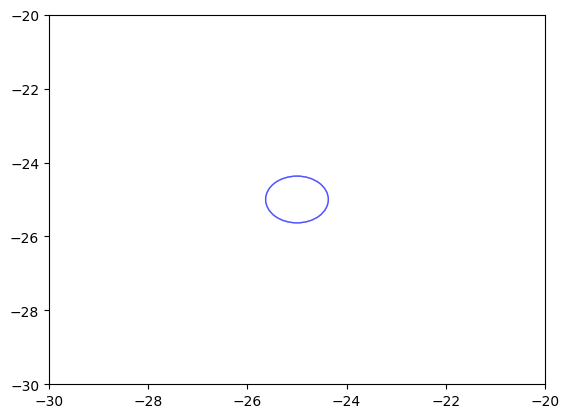

In [230]:
fig, ax = plt.subplots()
N = 20
mu_x = torch.linspace(-25, 25, N)
mu_y = torch.linspace(-25, 25, N)


vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]

rectangle = Polygon(vertices, closed=True, color='red')

s_N = 10
sigma2_x = torch.linspace(0.1, 3, s_N)
sigma2_y = torch.linspace(0.1, 3, s_N)

mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()]).T

sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")

pairs = torch.stack([sigma2_x_grid.flatten(), sigma2_y_grid.flatten()])
z = torch.zeros_like(pairs[0,:])
cov = torch.stack([pairs[0,:], z, z, pairs[1,:]], dim=0).reshape(2,2,-1).permute(2,0,1)

means.shape, cov.shape
# torch.cat((means, cov), dim=-1)
cov_list, mean_list = cov.repeat(N * N, 1, 1), means.repeat(s_N * s_N,1)

for i in range(10):
    print(mean_list[idx])
    print(cov_list[idx])
    print('---'*10)
    plot_ellipse(mean_list[idx], cov_list[idx], n_std=2, ax=ax, color='b', fill=False, alpha=0.1)
ax.set_xlim(-30, -20)
ax.set_ylim(-30, -20)
plt.show()

In [450]:
N = 7
mu_x = torch.linspace(0, 2, N)
mu_y = torch.linspace(0, 2, N)

mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing='ij')
means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()])


s_N = 4
sigma2_x = torch.linspace(1, 3, s_N)
sigma2_y = torch.linspace(1,3,s_N)

sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing='ij')

z = torch.zeros_like(sigma2_x_grid)
sigma2s = torch.stack([sigma2_x_grid.flatten(), z.flatten(), z.flatten(), sigma2_y_grid.flatten()])

print(means.shape, sigma2s.shape)
Mu = means.repeat(s_N*s_N, 1, 1).permute(0,2,1).transpose(0,1).flatten(0,1)
Sigma = sigma2s.repeat(N*N, 1, 1).permute(0,2,1).flatten(0,1)
samples = torch.cat([Mu, Sigma], dim=1)

# fig, ax = plt.subplots()
print('='*30)
print(len(samples))


mean_list = samples[:,:2]
cov_list = samples[:,2:].reshape(-1,2,2)

np.linalg.inv(cov_list)
# for sample in samples[:]:
#     mu = sample[:2]
#     Sigma = sample[2:].reshape(2,2)
    
#     plot_ellipse(mu, Sigma, n_std=2, ax=ax, color='b', fill=False, alpha=0.1)
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)
# plt.show()
# means_grid, Sigma_grid = torch.meshgrid(means.flatten(), sigma2s.flatten())
# means_grid.shape, Sigma_grid.shape
# torch.stack([means_grid.flatten(), Sigma_grid.flatten()]).shape

torch.Size([2, 49]) torch.Size([4, 16])
784


array([[[1.        , 0.        ],
        [0.        , 1.        ]],

       [[1.        , 0.        ],
        [0.        , 0.59999996]],

       [[1.        , 0.        ],
        [0.        , 0.42857143]],

       ...,

       [[0.33333334, 0.        ],
        [0.        , 0.59999996]],

       [[0.33333334, 0.        ],
        [0.        , 0.42857143]],

       [[0.33333334, 0.        ],
        [0.        , 0.33333334]]], dtype=float32)

In [362]:
torch.arange(81*6).reshape(81, 6)

tensor([[  0,   1,   2,   3,   4,   5],
        [  6,   7,   8,   9,  10,  11],
        [ 12,  13,  14,  15,  16,  17],
        [ 18,  19,  20,  21,  22,  23],
        [ 24,  25,  26,  27,  28,  29],
        [ 30,  31,  32,  33,  34,  35],
        [ 36,  37,  38,  39,  40,  41],
        [ 42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53],
        [ 54,  55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64,  65],
        [ 66,  67,  68,  69,  70,  71],
        [ 72,  73,  74,  75,  76,  77],
        [ 78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89],
        [ 90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101],
        [102, 103, 104, 105, 106, 107],
        [108, 109, 110, 111, 112, 113],
        [114, 115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124, 125],
        [126, 127, 128, 129, 130, 131],
        [132, 133, 134, 135, 136, 137],
        [138, 139, 140, 141, 142, 143],
        [144, 145, 146, 147, 148, 149],


In [207]:
from ipywidgets import interact, IntSlider

def plot(idx):
    N = 200
    mu_x = torch.linspace(-25, 25, N)
    mu_y = torch.linspace(-25, 25, N)
    
    
    vertices = [(mu_x.min(), mu_y.min()), (mu_x.min(), mu_y.max()), (mu_x.max(), mu_y.max()), (mu_x.max(), mu_y.min())]
    
    rectangle = Polygon(vertices, closed=True, color='red')

    s_N = 10
    sigma2_x = torch.linspace(0.1, 3, s_N)
    sigma2_y = torch.linspace(0.1, 3, s_N)
    
    mu_x_grid, mu_y_grid = torch.meshgrid(mu_x, mu_y, indexing="ij")
    means = torch.stack([mu_x_grid.flatten(), mu_y_grid.flatten()]).T
    
    sigma2_x_grid, sigma2_y_grid = torch.meshgrid(sigma2_x, sigma2_y, indexing="ij")
    
    pairs = torch.stack([sigma2_x_grid.flatten(), sigma2_y_grid.flatten()])
    z = torch.zeros_like(pairs[0,:])
    cov = torch.stack([pairs[0,:], z, z, pairs[1,:]], dim=0).reshape(2,2,-1).permute(2,0,1)

    mean_list = means.repeat(s_N*s_N, 1)
    cov_list = cov.repeat(N*N, 1, 1)
    fig, ax = plt.subplots(figsize=(5,5))
    
    
    print(mean_list[idx])
    print(cov_list[idx])
    plot_ellipse(mean_list[idx], cov_list[idx], n_std=2, ax=ax, color='g')
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    plt.show()

interact(
        plot,
        idx=IntSlider(min=0, max=200*200*10*10, step=1, value=0, description='Major Axis (a)'),
);


interactive(children=(IntSlider(value=0, description='Major Axis (a)', max=4000000), Output()), _dom_classes=(…

In [18]:
# 마할라노비스 거리 계산 함수
def mahalanobis_distance_batch(means, covs, point):
    # 공분산 행렬의 역행렬 계산
    cov_inv = torch.linalg.inv(covs)
    
    # 각 분포에 대해 마할라노비스 거리 계산
    # (point - mean)의 차이 벡터를 구하고, 이를 공분산 역행렬로 곱함
    diff = point - means
    mahalanobis_distances = torch.sqrt(torch.sum(diff @ cov_inv * diff, dim=1))
    
    return mahalanobis_distances


# 평균과 공분산 행렬을 4개 분포에 대해 정의
means = torch.tensor([[3, 4], [1, 2], [5, 6], [7, 8]], dtype=torch.float32)
covs = torch.tensor([[[4, 0], [0, 7]], 
                     [[2, 0], [0, 3]], 
                     [[6, 1], [1, 5]], 
                     [[8, 3], [3, 6]]], dtype=torch.float32)

point = torch.tensor([5, 7], dtype=torch.float32)

mahalanobis_distances_batch = mahalanobis_distance_batch(means, covs, point)

mahalanobis_distances_batch

tensor([[2.4495, 2.2678],
        [3.4641, 3.4641],
        [1.7811, 2.5461],
        [1.2403, 2.2871]])

In [22]:
from scipy.spatial import distance

def mahalanobis_batch(points, means, covariances):
    inv_covariances = np.linalg.inv(covariances)
    distances = [distance.mahalanobis(point, mean, inv_covariances) for point, mean in zip(points, means)]
    return distances

# 점 (4, 5)
point_batch = np.array([[4, 5]])

# 여러 정규분포의 평균과 공분산
means_batch = np.array([[7, 2], [6, 3], [8, 1]])
covariances_batch = np.array([[[5, 0], [0, 1]], [[4, 0], [0, 2]], [[6, 0], [0, 3]]])

# Mahalanobis distances 계산
distances_batch = mahalanobis_batch(point_batch, means_batch, covariances_batch)

distances_batch


array([[[2.30217289, 4.        ],
        [1.87971629, 3.26598632],
        [2.65832027, 4.61880215]]])

In [106]:
point = torch.tensor(np.array([-10.,6.]))

means = torch.tensor(np.array([[1,4], [3,4]]), dtype=torch.float)
covs = torch.tensor(
        np.array([
        [
            [8,0],
            [0,2]
        ],
        [
            [8,0],
            [0,2]
        ]
    ])
    , dtype=torch.float)

diff = means - point
dist = (diff[:,None,:] @ np.linalg.inv(covs) @ diff[:,None,:].permute(0,2,1))
print(dist)
dist.argmin().item()
# print((point - mean).T[:,:,None])
# print(cov.shape)
# print(np.linalg.inv(cov).shape)
# print((point - mean)[:,None,:] @ np.linalg.inv(cov) @ (point - mean).T[:,:,None])
# dist = (point - mean) @ np.linalg.inv(cov) @ (point - mean).T
# print(dist)

tensor([[[17.1250]],

        [[23.1250]]], dtype=torch.float64)


0

In [121]:

diff.norm(dim=1), (point - means[0]).norm()

(tensor([11.1803, 13.1529], dtype=torch.float64),
 tensor(11.1803, dtype=torch.float64))

In [33]:
sample_list = list()
for i in range(50):
    sample_list.append([-i, 0])
    
for i in range(50):
    sample_list.append([-50, i])
    
for i in range(100):
    sample_list.append([i-50, 50])
    
for i in range(100):
    sample_list.append([50, 50-i])
    
for i in range(150):
    sample_list.append([50-i, -50])
    
for i in range(150):
    sample_list.append([-100, i-50])
    
for i in range(200):
    sample_list.append([i-100, 100])
    
for i in range(200):
    sample_list.append([100, i-100])

In [34]:
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider
from tqdm import tqdm

for idx, (x,y) in tqdm(enumerate(sample_list)):
    fig, ax = plt.subplots(figsize=(8,8))
    
    sample = [x, y]
    input_data = torch.tensor(cart2polar(*sample), dtype=torch.float)[None,:]
    with torch.no_grad():
        pred = model(input_data)
    x_params = [pred[0][0,0], pred[1][0,0], pred[2][0,0], pred[3][0,0]]
    y_params = [pred[0][0,1], pred[1][0,1], pred[2][0,1], pred[3][0,1]]

    
    # ambiguity set
    ## x axis
    mu_0, lambda_, alpha, beta = x_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    x_mu_low, x_mu_high = mu_0 - delta, mu_0 + delta
    
    ## y axis
    mu_0, lambda_, alpha, beta = y_params
    try:
        zx, zy = a_memory[float(f'{alpha:.02f}')]
    except:
        zx, zy = a_memory[float(f'{1.01}')]
    delta = zx / np.sqrt(lambda_/beta)
    y_mu_low, y_mu_high = mu_0 - delta, mu_0 + delta
    
    vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
    
    rectangle = Polygon(vertices, closed=True, color='red')
    # sampling
    for _ in range(500):
        x_dist_params = NIG_sample(x_params)
        y_dist_params = NIG_sample(y_params)

        mean = np.array([x_dist_params[0], y_dist_params[0]])
        cov = np.array([
            [x_dist_params[1], 0],
            [0, y_dist_params[1]]
        ])


        # 공분산 행렬의 고유값과 고유벡터 계산
        eigvals, eigvecs = np.linalg.eigh(cov)

        # 1-sigma 수준에서 타원의 축 반지름 계산
        axis_lengths = np.sqrt(eigvals)

        # 타원의 각도 계산 (라디안)
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])

        # 타원 좌표 생성
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse = np.array([axis_lengths[0] * np.cos(theta), axis_lengths[1] * np.sin(theta)])

        # 타원의 회전 적용
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                     [np.sin(angle), np.cos(angle)]])
        rotated_ellipse = rotation_matrix @ ellipse

        # 타원을 평균 좌표로 이동
        ellipse_x, ellipse_y = rotated_ellipse[0] + mean[0], rotated_ellipse[1] + mean[1]
        if (x_mu_low < mean[0] and mean[0] < x_mu_high) and (y_mu_low < mean[1] and mean[1] < y_mu_high):
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        plt.plot(ellipse_x, ellipse_y, color=color, alpha=alpha, label=label)
    ax.add_patch(rectangle)

    plt.scatter(*sample, color='g', label='Ground Truth')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 중복 제거

    # 고유한 레이블만 포함하는 legend 표시
    plt.legend(unique_labels.values(), unique_labels.keys())   
    plt.savefig(f'record/{idx}.png')
    plt.close()


1000it [15:46,  1.06it/s]
